# The notebook is to generate $|z'\rangle$ from quantum part

2-regular graph with 4 nodes(a ring with $Z_4=Z_0$)
    \begin{eqnarray}
        H_c=-\sum_{i=0}^3\frac{Z_iZ_{i+1}}{2},\quad  H_b =\sum_{i=0}^3 X_i .
    \end{eqnarray}

In [1]:
import sys
sys.path.append("C:/Users/Mac/Documents/Code/quantum-arch-search/src/qas_gym/")

import numpy as np
from scipy.optimize import minimize
from scipy.linalg import expm
from utils import fidelity

# Define Pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])


# Tensor product function
def tensor_product(*args):
    result = np.array([1])
    for arg in args:
        result = np.kron(result, arg)
    return result

# Unitary evolution operators
def unitary(H, theta):
    return expm(-1j*H*theta)



# # Cost function
# def cost_function(params, p, initial_state, H_c, H_b):
#     gamma, beta = params
  
#     final_state = apply_circuit(gamma, beta, p, initial_state, H_c, H_b)
#     expectation_value = np.real(np.vdot(final_state, H_c @ final_state))
    
#     # Increment the counter and print every 10 iterations
#     global iteration_counter
#     iteration_counter += 1
#     if iteration_counter % 10 == 0:
#         print(f'Iteration: {iteration_counter}, gamma: {gamma:.4f}, beta: {beta:.4f}, cost: {expectation_value:.4f}')

    
    
#     return expectation_value


def find_ground_energy(hamiltonian):
    """
    Find the ground energy of a Hamiltonian.
    
    Parameters:
    hamiltonian (np.ndarray): The Hamiltonian matrix.
    
    Returns:
    float: The ground energy (lowest eigenvalue) of the Hamiltonian.
    """
    # Calculate the eigenvalues of the Hamiltonian
    eigenvalues = np.linalg.eigvalsh(hamiltonian)
    
    # Return the smallest eigenvalue
    return np.min(eigenvalues)



def gradient_operator(z, hamiltonian, xi):
    """
    Compute the gradient of the Hamiltonian with respect to a parameter.

    Parameters:
    hamiltonian (numpy.ndarray): The Hamiltonian matrix.
    xi (float): The scalar value representing the parameter with respect to which 
                the gradient is being computed.

    Returns:
    numpy.ndarray: The gradient matrix, which is the Hamiltonian scaled by the parameter xi.
    """
    
    # Compute the gradient by scaling the Hamiltonian with the parameter xi
    gradient = xi * hamiltonian
    result = xi*gradient @ z
    
    # Return the resulting gradient matrix
    return result



In [2]:
import matplotlib.pyplot as plt

# selected circuits
####QAOA circuit
def apply_circuit(gamma, beta, p, initial_state, H_c,H_b):
    state = initial_state
    # Define the Hamiltonians H_c and H_b
    for _ in range(p):
        state = unitary(H_c, gamma) @ state
        state = unitary(H_b, beta) @ state
    return state

#### rotational_qaoa
def apply_rotational_qaoa_circuit(gamma, beta, alpha, p, initial_state, H_c, H_b ):
    state = initial_state
    for _ in range(p):
#         state = single_qubit_rotation_y(state, alpha)
        state = unitary(H_c, gamma) @ state
        state = single_qubit_rotation_x(state, alpha)
        state = unitary(H_b, beta) @ state

    return state
def single_qubit_rotation_x(state, alpha):
    Rx = np.array([[np.cos(alpha / 2), -1j * np.sin(alpha / 2)],
                   [-1j * np.sin(alpha / 2), np.cos(alpha / 2)]])
    return tensor_product(Rx, Rx, Rx, Rx) @ state  # Extend to more qubits as needed

def single_qubit_rotation_y(state, alpha):
    Ry = np.array([[np.cos(alpha / 2), -np.sin(alpha / 2)],
                   [np.sin(alpha / 2), np.cos(alpha / 2)]])
    return tensor_product(Ry, Ry, Ry, Ry) @ state  # Extend to more qubits as needed


####hardware_efficient
def apply_hardware_efficient_ansatz(params, initial_state, layers, entangling_gate='CNOT'):
    state = initial_state
    num_qubits = int(np.log2(len(state)))
    
    state = unitary(tensor_product(I,I,Z,Z), params[0]) @unitary(tensor_product(Z,Z,I,I), params[1]) @state
    state = unitary(tensor_product(I,X,I,X), params[2]) @unitary(tensor_product(I,X,X,I), params[3]) @state

    return state

def single_qubit_rotation(state, alpha, qubit):
    # Rotation around the Y axis as an example
    Ry = np.array([[np.cos(alpha / 2), -np.sin(alpha / 2)],
                   [np.sin(alpha / 2), np.cos(alpha / 2)]])
    return apply_single_qubit_gate(state, Ry, qubit)


# def apply_cz_layer(state, num_qubits):
#     for i in range(num_qubits - 1):
#         state = apply_cz(state, i, i + 1)
#     return state
def apply_single_qubit_gate(state, gate, qubit):
    num_qubits = int(np.log2(len(state)))
    full_gate = np.eye(1)
    for i in range(num_qubits):
        full_gate = np.kron(full_gate, gate if i == qubit else np.eye(2))
    return full_gate @ state



####qcbm_ansatz
def apply_qcbm_ansatz(params, initial_state, layers):
    state = initial_state
    num_qubits = int(np.log2(len(state)))
    
    
    state = unitary(tensor_product(I,I,Z,Z), params[0]) @unitary(tensor_product(Z,Z,I,I), params[1]) @state
    state = single_qubit_rotation_y(state, params[4])
    state = single_qubit_rotation_y(state, params[5])
    state = unitary(tensor_product(I,Z,I,Z), params[2]) @unitary(tensor_product(I,Z,Z,I), params[3]) @state

    return state

# Cost function
def cost_function(params, p, initial_state, H_c, H_b, circuit='qaoa'):
    global iteration_counter
    
    if circuit == 'qaoa':
        gamma, beta = params
        final_state = apply_circuit(gamma, beta, p, initial_state, H_c, H_b)
    elif circuit == 'rotational_qaoa':
        gamma, beta, alpha = params
        final_state = apply_rotational_qaoa_circuit(gamma, beta, alpha, p, initial_state, H_c, H_b)
    elif circuit == 'hardware_efficient':
        final_state = apply_hardware_efficient_ansatz(params, initial_state, p)
    elif circuit == 'qcbm':
        final_state = apply_qcbm_ansatz(params, initial_state, p)
    
    expectation_value = np.real(np.vdot(final_state, H_c @ final_state))
    
    iteration_counter += 1
    if iteration_counter % 10 == 0:
        print(f'Iteration: {iteration_counter}, params: {params}, cost: {expectation_value:.4f}')
    
    return expectation_value


# Function to apply a small disturbance to the parameter set
def disturb_state(state, disturbance_magnitude=10*1e-1):
    # This is mimic the refinforcement part
    disturbance = disturbance_magnitude * np.random.randn(len(state))
    
    # Add the disturbance to the original parameters
    disturbed_state = state + disturbance
    disturbed_state = disturbed_state/ np.linalg.norm(disturbed_state)
    return disturbed_state


In [12]:
import gym
import numpy as np
import torch.optim as optim
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import qas_gym
import warnings

def PQC_RL(env, learn_steps, state_in, f_in):
    """
    Compute parameterized quantum circuit that tranform state_in to state_out.

    Parameters:
        env (environment): the defined qas_env environment with corresponding initial and target state.
        learn_steps: number of episodes to learn policy
        state_in: initial state
        f_in: initial fidelity  (the logic is if the best fidelity value after learning is no better that the initial value, then return the initial state)

    Returns:
        max_fstate: state with max fidelity
        max_fidelity: max fidelity with learned policy
    """


    # Parameters
    gamma = 0.99
    n_epochs = 4
    clip_range = 0.2
    learning_rate = 0.0001
    policy_kwargs = dict(optimizer_class=optim.Adam)

    # Agent
    ppo_model = PPO("MlpPolicy",
                    env,
                    gamma=gamma,
                    n_epochs=n_epochs,
                    clip_range=clip_range,
                    learning_rate=learning_rate,
                    policy_kwargs=policy_kwargs,
                    tensorboard_log='logs/')
    
    ppo_model.learn(total_timesteps=learn_steps)
    
    # simulate to get fidelity
    state = env.reset()

    # set max_fidelity, max_fstate to the initial value
    max_fidelity = f_in
    max_fstate = state_in

    done = False
    while not done:
        action = ppo_model.predict(state)
        state, reward, done, info = env.step(action[0])
        #展示当前的线路 和 state
        # env.render()
        # print(state)
        # print(info['fidelity'])
        if info['fidelity'] > max_fidelity:
            max_fidelity = info['fidelity']
            max_fstate = info['state']
    return max_fstate, max_fidelity


def get_PQC_state(state_in, state_out, env_name='BasicFourQubit-v0',reward_penalty = 0.01,max_depth = 10,fidelity_threshold=0.99,train_steps=10000):
    f_ini = fidelity(state_out, state_in)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        env = gym.make(env_name, target = state_out,
                fidelity_threshold=fidelity_threshold,
                reward_penalty=reward_penalty,
                max_timesteps=max_depth,
                initial = state_in)
        
        a, b = PQC_RL(env, train_steps, state_in, f_ini)
    return a, b 

Pre-train with an initial PQC, circuit formulates like this: $[e ^{-i H_b \beta}e^{-iH_c \gamma}]$, Then, using quantum gradient algorithm, we can obtain an updated $|z'\rangle$

hardware_efficient - Program 2
Iteration: 10, params: [0.66608738 1.5414106  0.22287955 0.61271068], cost: -0.9513
Iteration: 20, params: [0.627058   1.69868568 0.26911137 0.53194648], cost: -0.9977
Iteration: 30, params: [0.64280211 1.71473307 0.27481899 0.51047041], cost: -1.0000
Iteration: 40, params: [0.64218885 1.71413216 0.2756305  0.51065692], cost: -1.0000
Iteration: 50, params: [0.64181162 1.71381138 0.27475516 0.51051251], cost: -1.0000
Iteration: 60, params: [0.64201774 1.71431484 0.27484427 0.51076209], cost: -1.0000
Optimal parameters for hardware_efficient: [0.64203791 1.71427366 0.27469766 0.51059067]
Iteration(Quantum, hardware_efficient): 1
Initial fidelity : 0.9557: 
 fidelity after PQC : 0.9557
cost: -1.0000
Iteration(Quantum, hardware_efficient): 2
Initial fidelity : 0.9557: 
 fidelity after PQC : 0.9764
cost: -1.3564
Iteration(Quantum, hardware_efficient): 3
Initial fidelity : 0.9640: 
 fidelity after PQC : 0.9642
cost: -1.3572
Iteration(Quantum, hardware_efficient

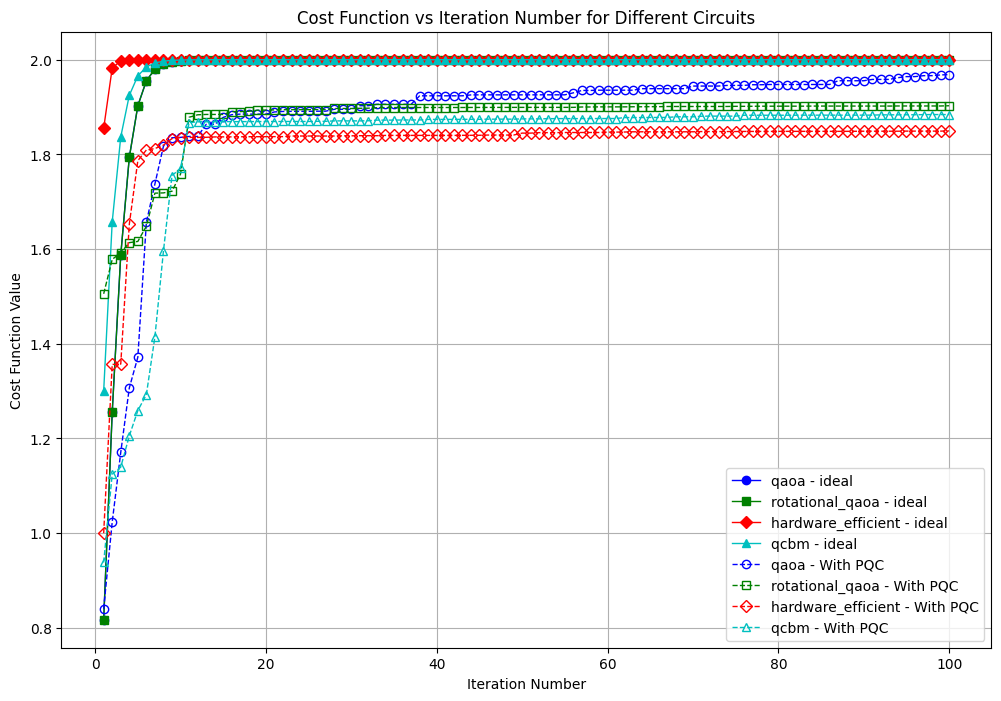

In [25]:
# Define the Hamiltonians H_c and H_b
H_c = (tensor_product(Z, Z, I, I)+tensor_product(I, Z, Z, I)+tensor_product(I, I, Z, Z)+tensor_product(I, Z, I, Z))
H_b = tensor_product(X, I, I, I)+tensor_product(I, X, I, I)+tensor_product(I, I, X, I)+tensor_product(I, I, I, X)  

# Initial state |+>^4 = (|0> + |1>)/sqrt(2) ⊗ 4
initial_state = tensor_product(np.array([1, 1]) / np.sqrt(2), 
                               np.array([1, 1]) / np.sqrt(2),
                               np.array([1, 1]) / np.sqrt(2),
                               np.array([1, 1]) / np.sqrt(2))

# Parameters for each circuit ansatz
circuits = ['qaoa', 'rotational_qaoa', 'hardware_efficient', 'qcbm']
initial_params_dict = {
    'qaoa': np.random.rand(2),  # Initial guess for gamma and beta
    'rotational_qaoa': np.random.rand(3),  # Initial guess for gamma, beta, and alpha
    'hardware_efficient': np.random.rand(4),  # Adjust number of params as needed
    'qcbm': np.random.rand(6),  # Adjust number of params as needed
}

xi = 0.5
termination_number = 100
hamiltonian = H_c

# To store cost values for plotting from both programs
cost_values_dict_1 = {circuit: [] for circuit in circuits}
cost_values_dict_2 = {circuit: [] for circuit in circuits}
markers = ['o', 's', 'D', '^']  # Different markers for each circuit
colors = ['b', 'g', 'r', 'c']
line_width = 1


# First program: Without state disturbance
for circuit in circuits:
    iteration_counter = 0
    print(f"{circuit} - Program 1")
    result = minimize(cost_function, initial_params_dict[circuit], args=(1, initial_state, H_c, H_b, circuit), method='COBYLA')
    print(f'Optimal parameters for {circuit}: {result.x}')
    
    # Use the optimized parameters to apply the circuit
    if circuit == 'qaoa':
        optimal_gamma, optimal_beta = result.x
        state_in = apply_circuit(optimal_gamma, optimal_beta, 1, initial_state, H_c, H_b)
    elif circuit == 'rotational_qaoa':
        optimal_gamma, optimal_beta, optimal_alpha = result.x
        state_in = apply_rotational_qaoa_circuit(optimal_gamma, optimal_beta, optimal_alpha, 1, initial_state, H_c, H_b)
    elif circuit == 'hardware_efficient':
        state_in = apply_hardware_efficient_ansatz(result.x, initial_state, 1)
    elif circuit == 'qcbm':
        state_in = apply_qcbm_ansatz(result.x, initial_state, 1)
    
    # Gradient-based update loop
    for jj in range(termination_number):
        state_out = state_in - gradient_operator(state_in, hamiltonian, xi)
        state_out = state_out / np.linalg.norm(state_out)
        expectation_value = np.real(np.vdot(state_out, H_c @ state_out))
        state_in = state_out
        cost_values_dict_1[circuit].append(-expectation_value)
        if jj % 10 == 0:
            print(f'Iteration(Quantum, {circuit}): {jj + 1}, cost: {expectation_value:.4f}')

# Second program: With state disturbance
for circuit in circuits[2:]:
    iteration_counter = 0
    print(f"{circuit} - Program 2")
    result = minimize(cost_function, initial_params_dict[circuit], args=(1, initial_state, H_c, H_b, circuit), method='COBYLA')
    print(f'Optimal parameters for {circuit}: {result.x}')
    
    # Use the optimized parameters to apply the circuit
    if circuit == 'qaoa':
        optimal_gamma, optimal_beta = result.x
        state_in = apply_circuit(optimal_gamma, optimal_beta, 1, initial_state, H_c, H_b)
    elif circuit == 'rotational_qaoa':
        optimal_gamma, optimal_beta, optimal_alpha = result.x
        state_in = apply_rotational_qaoa_circuit(optimal_gamma, optimal_beta, optimal_alpha, 1, initial_state, H_c, H_b)
    elif circuit == 'hardware_efficient':
        state_in = apply_hardware_efficient_ansatz(result.x, initial_state, 1)
    elif circuit == 'qcbm':
        state_in = apply_qcbm_ansatz(result.x, initial_state, 1)
    
    # Gradient-based update loop
    for jj in range(termination_number):
        print(f'Iteration(Quantum, {circuit}): {jj + 1}')
        state_out = state_in - gradient_operator(state_in, hamiltonian, xi)
        state_out = state_out / np.linalg.norm(state_out)
        # state_in = disturb_state(state_out, disturbance_magnitude=3e-2)################################# replace

        print("Initial fidelity : {:.4f}: ".format(fidelity(state_out, state_in)))
        state_in, fidelity_j = get_PQC_state(state_in, state_out)
        print(" fidelity after PQC : {:.4f}".format(fidelity_j))
        expectation_value = np.real(np.vdot(state_in, H_c @ state_in))  
        print(f'cost: {expectation_value:.4f}')
        cost_values_dict_2[circuit].append(-expectation_value)
        # if jj % 10 == 0:
        #     print(f'Iteration(Quantum, {circuit}): {jj + 1}, cost: {expectation_value:.4f}')

# Combined plotting
plt.figure(figsize=(12, 8))

# Plot results from the first program
for idx, circuit in enumerate(circuits):
    plt.plot(range(1, termination_number + 1), cost_values_dict_1[circuit], label=f'{circuit} - ideal', marker=markers[idx],color =colors[idx], linewidth=line_width, linestyle='-')

# Plot results from the second program
for idx, circuit in enumerate(circuits):
    plt.plot(range(1, termination_number + 1), cost_values_dict_2[circuit], label=f'{circuit} - With PQC', marker=markers[idx], markerfacecolor='None',color =colors[idx],linewidth=line_width,  linestyle='--')

plt.title('Cost Function vs Iteration Number for Different Circuits')
plt.xlabel('Iteration Number')
plt.ylabel('Cost Function Value')
plt.legend()
plt.grid(True)
# Save the figure as a PDF
plt.savefig("example1.pdf", format='pdf', bbox_inches='tight')

plt.show()

In [24]:
cost_values_dict_2['rotational_qaoa'] 

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assuming functions tensor_product, apply_circuit, apply_rotational_qaoa_circuit,
# apply_hardware_efficient_ansatz, apply_qcbm_ansatz, gradient_operator, disturb_state, 
# cost_function, and initial_function are already defined

# Define the Hamiltonians H_c and H_b
H_c = (tensor_product(Z, Z, I, I) + tensor_product(I, Z, Z, I) + tensor_product(I, I, Z, Z) + tensor_product(I, Z, I, Z))
H_b = (tensor_product(X, I, I, I) + tensor_product(I, X, I, I) + tensor_product(I, I, X, I) + tensor_product(I, I, I, X))

# Initial state |+>^4 = (|0> + |1>)/sqrt(2) ⊗ 4
initial_state = tensor_product(np.array([1, 1]) / np.sqrt(2), 
                               np.array([1, 1]) / np.sqrt(2),
                               np.array([1, 1]) / np.sqrt(2),
                               np.array([1, 1]) / np.sqrt(2))

# Parameters for each circuit ansatz
circuits = ['qaoa', 'rotational_qaoa', 'hardware_efficient', 'qcbm']
initial_params_dict = {
    'qaoa': np.random.rand(2),  # Initial guess for gamma and beta
    'rotational_qaoa': np.random.rand(3),  # Initial guess for gamma, beta, and alpha
    'hardware_efficient': np.random.rand(4),  # Adjust number of params as needed
    'qcbm': np.random.rand(6),  # Adjust number of params as needed
}

xi = 0.5
termination_number = 50
hamiltonian = H_c
num_runs = 10  # Number of runs to average over

# To store cost values for plotting from both programs
cost_values_dict_1 = {circuit: [] for circuit in circuits}
cost_values_dict_2 = {circuit: [] for circuit in circuits}
markers = ['o', 's', 'D', '^']  # Different markers for each circuit
colors = ['b', 'g', 'r', 'c']
line_width = 1

# First program: Without state disturbance
for circuit in circuits:
    iteration_counter = 0
    print(f"{circuit} - Program 1")
    result = minimize(cost_function, initial_params_dict[circuit], args=(1, initial_state, H_c, H_b, circuit), method='COBYLA')
    print(f'Optimal parameters for {circuit}: {result.x}')
    
    # Use the optimized parameters to apply the circuit
    if circuit == 'qaoa':
        optimal_gamma, optimal_beta = result.x
        state_in = apply_circuit(optimal_gamma, optimal_beta, 1, initial_state, H_c, H_b)
    elif circuit == 'rotational_qaoa':
        optimal_gamma, optimal_beta, optimal_alpha = result.x
        state_in = apply_rotational_qaoa_circuit(optimal_gamma, optimal_beta, optimal_alpha, 1, initial_state, H_c, H_b)
    elif circuit == 'hardware_efficient':
        state_in = apply_hardware_efficient_ansatz(result.x, initial_state, 1)
    elif circuit == 'qcbm':
        state_in = apply_qcbm_ansatz(result.x, initial_state, 1)
    
    # Gradient-based update loop
    for jj in range(termination_number):
        state_out = state_in - gradient_operator(state_in, hamiltonian, xi)
        state_out = state_out / np.linalg.norm(state_out)
        expectation_value = np.real(np.vdot(state_out, H_c @ state_out))
        state_in = state_out
        cost_values_dict_1[circuit].append(-expectation_value)
        if jj % 10 == 0:
            print(f'Iteration(Quantum, {circuit}): {jj + 1}, cost: {expectation_value:.4f}')

# Second program: With state disturbance averaged over multiple runs
for circuit in circuits:
    iteration_counter = 0
    print(f"{circuit} - Program 2")
    result = minimize(cost_function, initial_params_dict[circuit], args=(1, initial_state, H_c, H_b, circuit), method='COBYLA')
    print(f'Optimal parameters for {circuit}: {result.x}')
    
    # Use the optimized parameters to apply the circuit
    if circuit == 'qaoa':
        optimal_gamma, optimal_beta = result.x
        state_in = apply_circuit(optimal_gamma, optimal_beta, 1, initial_state, H_c, H_b)
    elif circuit == 'rotational_qaoa':
        optimal_gamma, optimal_beta, optimal_alpha = result.x
        state_in = apply_rotational_qaoa_circuit(optimal_gamma, optimal_beta, optimal_alpha, 1, initial_state, H_c, H_b)
    elif circuit == 'hardware_efficient':
        state_in = apply_hardware_efficient_ansatz(result.x, initial_state, 1)
    elif circuit == 'qcbm':
        state_in = apply_qcbm_ansatz(result.x, initial_state, 1)
    
    # Gradient-based update loop with averaging
    average_cost_values = np.zeros(termination_number)
    
    for run in range(num_runs):
        state_in_run = state_in
        for jj in range(termination_number):
            state_out = state_in_run - gradient_operator(state_in_run, hamiltonian, xi)
            state_out = state_out / np.linalg.norm(state_out)
            # state_in_run = disturb_state(state_out, disturbance_magnitude=3e-2) ################################# replace
            print("Initial fidelity : {:.4f}: ".format(fidelity(state_out, state_in_run)))
            state_in_run, fidelity_j = get_PQC_state(state_in_run, state_out)
            print(" fidelity after PQC : {:.4f}".format(fidelity_j))
            expectation_value = np.real(np.vdot(state_in_run, H_c @ state_in_run))
            average_cost_values[jj] += expectation_value/num_runs
        
#         # Divide by number of runs to get the average
#         average_cost_values /= num_runs

    # Store averaged cost values
    cost_values_dict_2[circuit] = -average_cost_values
#     if jj % 2 == 0:
#         print(f'Iteration(Quantum, {circuit} - Averaged): {jj + 1}, cost: {average_cost_values[jj]:.4f}')

# Combined plotting
plt.figure(figsize=(12, 8))

# Plot results from the first program
for idx, circuit in enumerate(circuits):
    plt.plot(range(1, termination_number + 1), cost_values_dict_1[circuit], label=f'{circuit} - ideal', marker=markers[idx], color=colors[idx], linewidth=line_width, linestyle='-')

# Plot results from the second program
for idx, circuit in enumerate(circuits):
    plt.plot(range(1, termination_number + 1), cost_values_dict_2[circuit], label=f'{circuit} - With PQC (Averaged)', marker=markers[idx], markerfacecolor='None', color=colors[idx], linewidth=line_width, linestyle='--')

plt.title('Cost Function vs Iteration Number for Different Circuits')
plt.xlabel('Iteration Number')
plt.ylabel('Cost Function Value')
plt.legend()
plt.grid(True)
# Save the figure as a PDF
# plt.savefig("example1_3.pdf", format='pdf', bbox_inches='tight')

plt.show()


qaoa - Program 1
Iteration: 10, params: [-0.3124621   0.59869426], cost: -0.4574
Iteration: 20, params: [-0.31540995  0.3340442 ], cost: -1.4253
Iteration: 30, params: [-0.32616108  0.32940715], cost: -1.4270
Optimal parameters for qaoa: [-0.32641643  0.32925223]
Iteration(Quantum, qaoa): 1, cost: -1.7392
Iteration(Quantum, qaoa): 11, cost: -1.9999
Iteration(Quantum, qaoa): 21, cost: -2.0000
Iteration(Quantum, qaoa): 31, cost: -2.0000
Iteration(Quantum, qaoa): 41, cost: -2.0000
Iteration(Quantum, qaoa): 51, cost: -2.0000
Iteration(Quantum, qaoa): 61, cost: -2.0000
Iteration(Quantum, qaoa): 71, cost: -2.0000
Iteration(Quantum, qaoa): 81, cost: -2.0000
Iteration(Quantum, qaoa): 91, cost: -2.0000
rotational_qaoa - Program 1
Iteration: 10, params: [2.03357671 0.59046927 1.19429603], cost: -0.1902
Iteration: 20, params: [1.94290125 0.49928473 1.25002613], cost: -0.2368
Iteration: 30, params: [1.95534659 0.41924597 1.1813794 ], cost: -0.2600
Iteration: 40, params: [1.9490529  0.4063517  1.15

KeyboardInterrupt: 

In [29]:
# import os
# os.system('pip install dill')
import dill
dill.dump_session('notebook_example1.db')
# dill.load_session('notebook_example1.db')

In [31]:
fidelity_j

0.9939084691018182